### **Tracks the electric power consumption of a household** 📊🏦

#### **Introduction**
Forecasting energy consumption helps ensure the grid provides enough energy for households, allowing energy companies
to plan load, produce enough during peak times, and avoid excess electricity, preventing grid imbalance and
disconnection risks.
    
#### **Description Data** 
The dataset to explore consists of three years of hourly electricity load and temperature, between 2012 and
2014. It contains the following columns:

    1. Date – the actual date the measurement was recorded
    2. Hour – the actual hour the measurement was recorded
    3. Load value – the actual consumption measured in kWh (kilowatt-hour)
    4. Temperature – the temperature collected in degrees Celsius

#### **Objective of the project**
The objective of this project is to make one-step and multi-step forecast of electric energy consumption with
several kinds of models:
Statistical models:
Select/derive a subset of data manageable by statistical models
Model the series with an adequate statistical function
Machine learning models:
Using several regression algorithms
Deep learning models:
Using LSTM and GRU networks
Evaluate the models, compare them at least with one baseline model.
Select the best-performing model.

#### **Data preparation and exploration**

**1. Import necessary libraries and set settings**

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import GRU

# Settings
pd.options.display.max_columns = None
pd.options.display.max_rows = None
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

**2. Import and analyse the dataset**

In [45]:
df = pd.read_excel('energy_demand.xlsx')

df.head()

,Date,Hour,load,T
0,2012-01-01,0,2872.0,30.666667
1,2012-01-01,1,2698.0,32.000000
2,2012-01-01,2,2558.0,32.666667
3,2012-01-01,3,2444.0,30.000000
4,2012-01-01,4,2402.0,31.000000


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26305 entries, 0 to 26304
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    26305 non-null  datetime64[ns]
 1   Hour    26305 non-null  int64         
 2   load    26305 non-null  float64       
 3   T       26305 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 822.2 KB


In [47]:
df.describe()

,Hour,load,T
count,26305.000000,26305.000000,26305.000000
mean,12.499525,3303.752785,47.764988
std,6.922616,564.574798,19.338062
min,0.000000,1979.000000,-13.666667
25%,6.000000,2867.000000,32.666667
50%,12.000000,3364.000000,48.333333
75%,18.000000,3690.000000,63.666667
max,24.000000,5224.000000,95.000000


**3. Apply some data transformations**

In [48]:
# Check for missing values and duplicates
total_missing = df.isna().sum().sum()
total_duplicates = df.duplicated().sum()

print("\nTotal missing Values:", total_missing)
print("\nTotal duplicates:", total_duplicates)


Total missing Values: 0

Total duplicates: 0


In [49]:
if 'Date' in df.columns and 'Hour' in df.columns:
    # Adjust 'Hour' values to be within the 0-23 range
    df['Hour'] = df['Hour'] % 24

    # Combine 'Date' and adjusted 'Hour' columns into a single datetime column
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Hour'].astype(str) + ':00:00')

    # Drop the original 'Date' and 'Hour' columns
    df.drop(['Date', 'Hour'], axis=1, inplace=True)
    
    # Set the datetime column as the index for time series analysis
    df.set_index('DateTime', inplace=True)

else:
    print("The columns 'Date' and 'Hour' don't exist")

**4. Check correlations**

<Axes: >

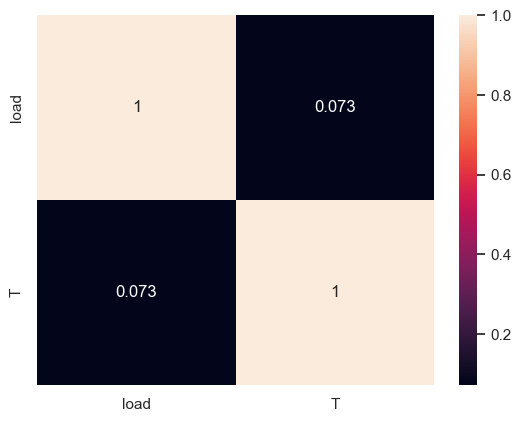

In [50]:
sns.heatmap(df.corr(), annot=True)

**Notes**
- The correlation heatmap shows a strong correlation between temperature and consumption.

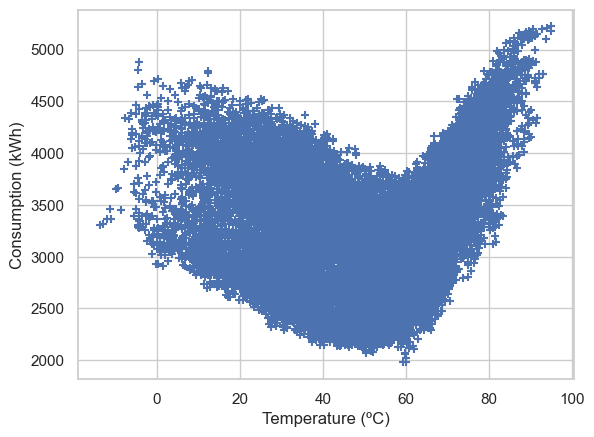

In [51]:
plt.scatter(df['T'], df['load'], marker='+')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Consumption (kWh)')
plt.show()

**Notes**
- It's notable an increase of energy consumption when the temperatures are lower or too high

#### **Time Series Analysis**

**1. Components of a Time Series**

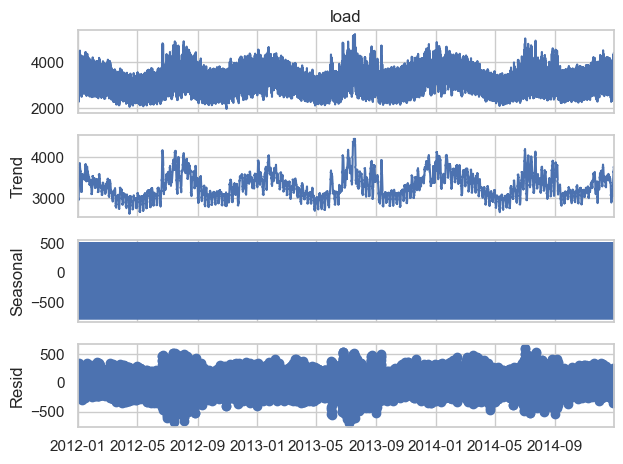

In [52]:
result = seasonal_decompose(df['load'], model='additive', period=24)
result.plot()
plt.show()

**2. ADCF Test to check if the series is stationary**

In [53]:
ADF_result = adfuller(df['load'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.406281746483964
p-value: 1.853221957622963e-18


**Notes**

- ADF statistic, which is a negative number we can reject the null hypothesis
- P-value is less than 0.05, we can also reject the null hypothesis and say 
the series is stationary
- The Dataset is stationary


**3. Plot the autocorrelation function - ACF**

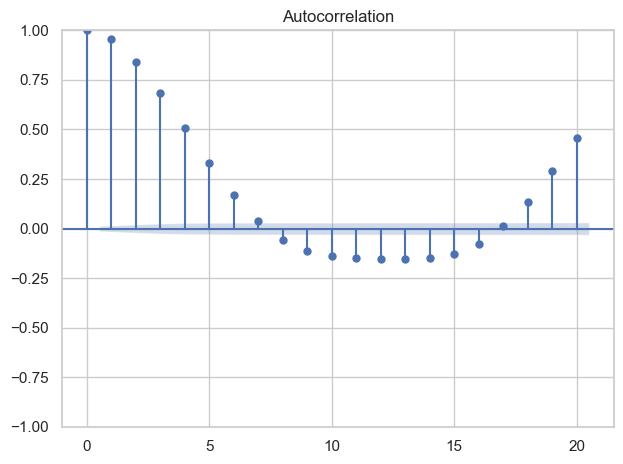

In [54]:
plot_acf(df['load'], lags=20)
plt.tight_layout()

**4. Plot the partial autocorrelation function - PACF**

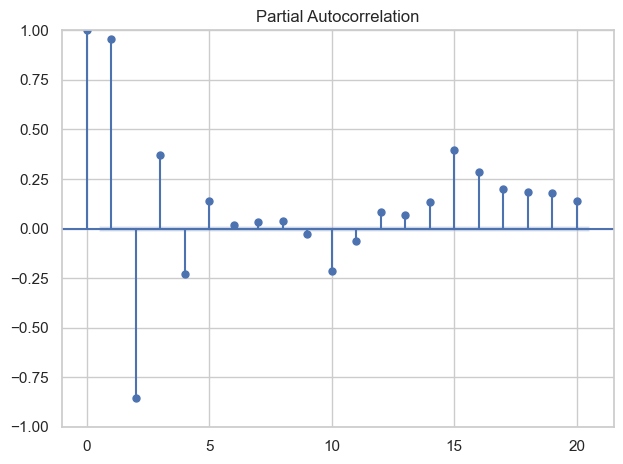

In [55]:
plot_pacf(df['load'], lags=20)
plt.tight_layout()

**Notes**

- There are significant coefficients after lag 0, which is not a indicator of a 
random walk


### **ForeCasting an Autoregressive Moving Average model ARMA(p,q)**

**1. Split data**

In [56]:
df_diff = pd.DataFrame({'load_diff': df['load']})

split_date = '2014-01-01'

train_arma = df_diff.loc[df.index < split_date].copy()

test_arma = df_diff.loc[df.index >= split_date].copy()

print(len(train_arma))
print(len(test_arma))

17545
8760


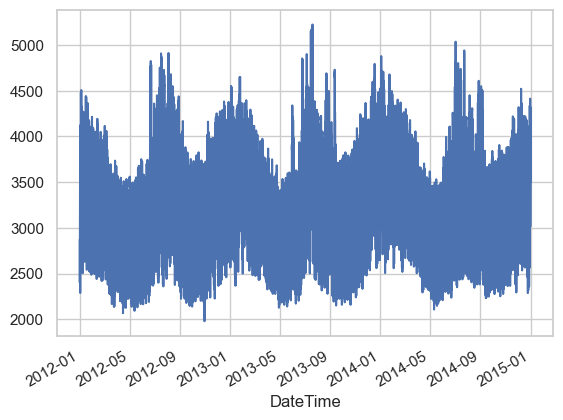

In [57]:
df_diff['load_diff'].plot()
plt.show()

**2. Calculate Akaike information criterion (AIC)**

In [58]:
def optimize_ARMA(df, order_list):
    results = []
    for order in order_list:
        try:
            model = SARIMAX(df, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic 
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [59]:
ps = range(0, 4, 1)
print('ps', ps)
qs = range(0, 4, 1)
print('qs', qs)
order_list = list(product(ps, qs))
print('order_list:\n', order_list[:3])
print('\n ....')
print(order_list[-3:])
print(len(order_list))


result_df = optimize_ARMA(train_arma, order_list)
result_df

ps range(0, 4)
qs range(0, 4)
order_list:
 [(0, 0), (0, 1), (0, 2)]

 ....
[(3, 1), (3, 2), (3, 3)]
16


,"(p,q)",AIC
0,"(3, 2)",202061.051146
1,"(3, 1)",204755.625848
2,"(3, 3)",204809.100612
3,"(2, 3)",204817.986745
4,"(2, 2)",204834.359324
5,"(2, 1)",205126.701305
6,"(3, 0)",205394.764274
7,"(1, 3)",205401.979789
8,"(1, 2)",207060.797262
9,"(2, 0)",210530.287389


**Notes**

- (3, 2) as (p,q) shows the lowest AIC value
- AIC = 202061.051146 


**3. Analyze SARIMAX Results**

                               SARIMAX Results                                
Dep. Variable:              load_diff   No. Observations:                17545
Model:               SARIMAX(3, 0, 2)   Log Likelihood             -101024.526
Date:                Sun, 31 Dec 2023   AIC                         202061.051
Time:                        18:04:38   BIC                         202107.686
Sample:                             0   HQIC                        202076.406
                              - 17545                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6520      0.003    906.375      0.000       2.646       2.658
ar.L2         -2.4096      0.004   -607.576      0.000      -2.417      -2.402
ar.L3          0.7576      0.001    650.712      0.0

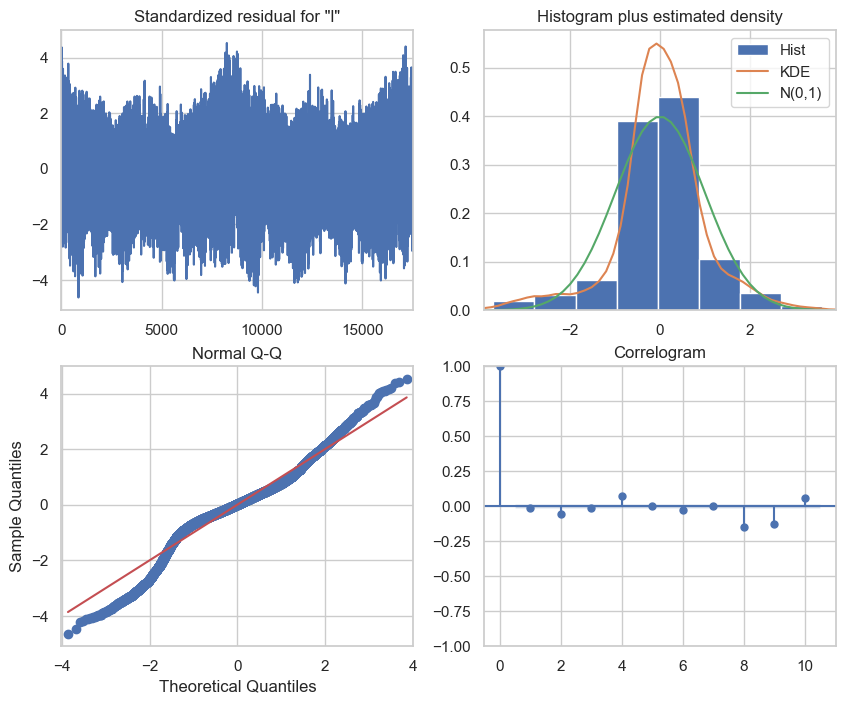

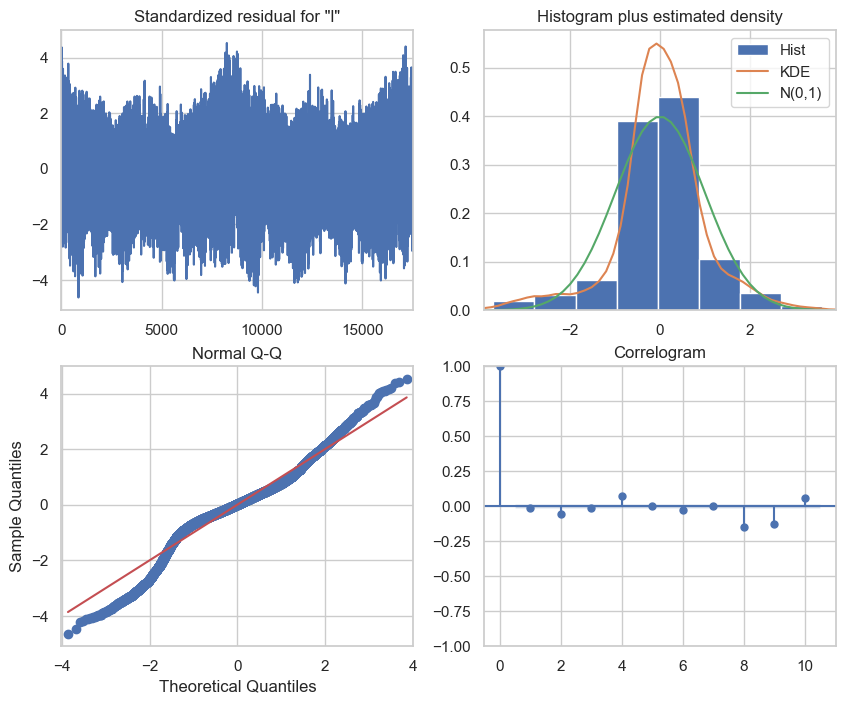

In [60]:
model = SARIMAX(train_arma, order=(3, 0, 2), simple_differencing=False)

model_fit = model.fit(disp=False)

print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(10, 8))

In [61]:
residuals = model_fit.resid
residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))

residuals_test['lb_pvalue']

1      1.652150e-02
2      6.889083e-11
3      6.036391e-11
4      8.918723e-29
5      5.586346e-28
6      2.671248e-29
7      1.106944e-28
8     2.628691e-100
9     1.919340e-151
10    2.806296e-163
Name: lb_pvalue, dtype: float64

In [62]:
def rolling_forecast(df, train_len, horizon, window, method):
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = np.repeat(np.mean(df[:train_len].values), total_len)

        return pred_mean
    elif method == 'last':
        last_value = df.iloc[train_len - 1].values[0]
        pred_last_value = np.repeat(last_value, total_len)

        return pred_last_value
    elif method == 'ARMA':
        model = SARIMAX(df[:train_len], order=(2, 0, 2))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, total_len - 1)
        pred_ARMA = predictions.predicted_mean.values

        return pred_ARMA

In [63]:
TRAIN_LEN = len(train_arma)
HORIZON = len(test_arma)
WINDOW = 2

# Perform rolling forecasts
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

# Update the 'test' DataFrame with the predictions
test_arma['pred_mean'] = pred_mean[:HORIZON]
test_arma['pred_last_value'] = pred_last_value[:HORIZON]
test_arma['pred_ARMA'] = pred_ARMA[:HORIZON]

In [64]:
mse_mean = mean_squared_error(test_arma['load_diff'], test_arma['pred_mean'])
mse_last = mean_squared_error(test_arma['load_diff'], test_arma['pred_last_value'])
mse_ARMA = mean_squared_error(test_arma['load_diff'], test_arma['pred_ARMA'])

print('MSE historical Mean', round(mse_mean, 3))
print('MSE last value', round(mse_last, 3))
print('MSE ARMA(2)', round(mse_ARMA, 3))

MSE historical Mean 301711.77
MSE last value 325566.248
MSE ARMA(2) 196935.768


**4. Plot Prediction Load**

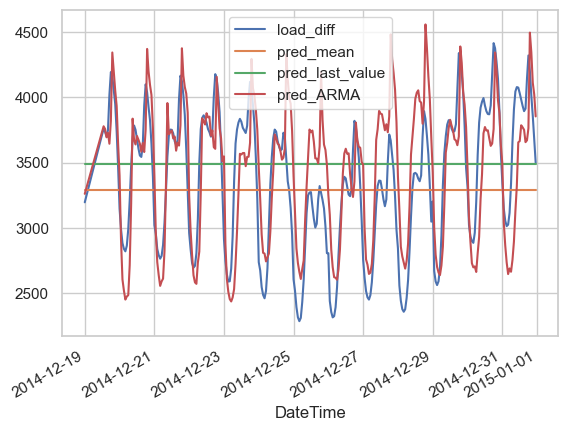

In [65]:
test_arma.iloc[-300:].plot()
plt.show()

### **Time series forecasting with Machine Learning**

**1. Split data by Time**

Since time matters in time series data, data should be split based on time, rather  than randomly

    Split Points
    - Training set: must be the earlier portion of the time series, 70-80% of the data 
    - Validation set: the next 10-15% of the data after the training set
    - Test set: the remaining data, the last 15-20%

In [66]:
split_date_train = '2014-01-01'
split_date_val = '2014-09-01'

train = df[df.index < split_date_train]

validation = df[(df.index >= split_date_train) & (df.index < split_date_val)]

test = df[df.index >= split_date_val]

**2. Data normalization**

In [67]:
scaler = MinMaxScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)

validation_scaled = pd.DataFrame(scaler.transform(validation), columns=validation.columns, index=validation.index)

test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

train_scaled.head()

,load,T
DateTime,,
2012-01-01 00:00:00,0.275193,0.373377
2012-01-01 01:00:00,0.221572,0.386364
2012-01-01 02:00:00,0.178428,0.392857
2012-01-01 03:00:00,0.143297,0.366883
2012-01-01 04:00:00,0.130354,0.376623


**3. Time series data transformation**
- Five-period sliding window for single-step forecast

In [68]:
for i in range(1, 6):
    train_scaled[f'x_{i}'] = train_scaled['load'].shift(i)
    validation_scaled[f'x_{i}'] = validation_scaled['load'].shift(i)
    test_scaled[f'x_{i}'] = test_scaled['load'].shift(i)

# Drop NaN values after shifting by 5 periods
X_train = train_scaled[['x_1', 'x_2', 'x_3', 'x_4', 'x_5']].dropna()
y_train = train_scaled['load'].shift(-5).dropna()

X_validation = validation_scaled[['x_1', 'x_2', 'x_3', 'x_4', 'x_5']].dropna()
y_validation = validation_scaled['load'].shift(-5).dropna()

X_test = test_scaled[['x_1', 'x_2', 'x_3', 'x_4', 'x_5']].dropna()
y_test = test_scaled['load'].shift(-5).dropna()

In [69]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17540, 5)
X_test shape: (2923, 5)
y_train shape: (17540,)
y_test shape: (2923,)


**4. Linear Regression**

Mean Squared Error (Linear Regression): 0.0005526095895797445
Mean Absolute Error (Linear Regression): 0.01664332182479852
R-squared (Linear Regression): 0.9780635214420328


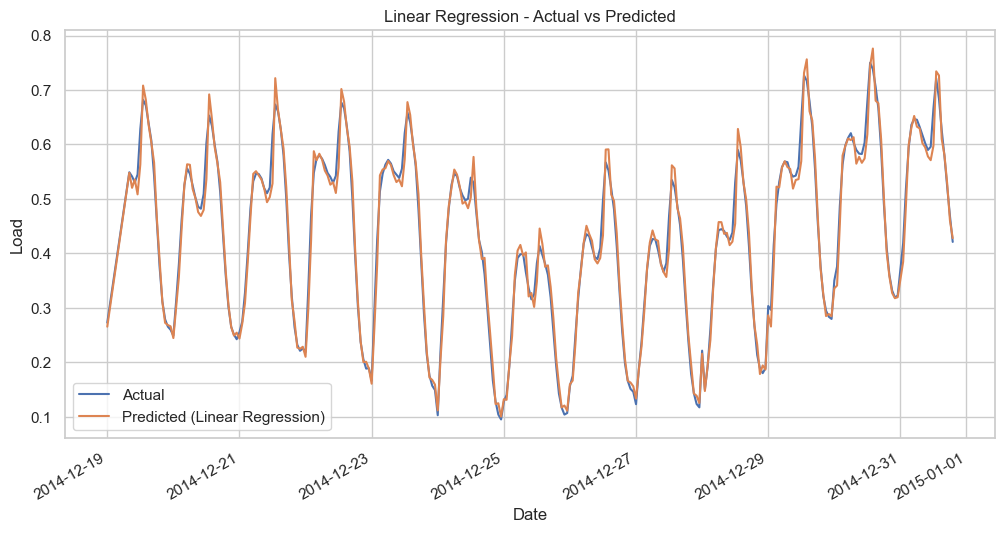

In [70]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred_lr = model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_lr)
mae_dt = mean_absolute_error(y_test, y_pred_lr)
r2_dt = r2_score(y_test, y_pred_lr)

print("Mean Squared Error (Linear Regression):", mse_dt)
print("Mean Absolute Error (Linear Regression):", mae_dt)
print("R-squared (Linear Regression):", r2_dt)

plt.figure(figsize=(12, 6))
y_test[-300:].plot(label='Actual')
pd.Series(y_pred_lr, index=y_test.index)[-300:].plot(label='Predicted (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Linear Regression - Actual vs Predicted')
plt.legend()
plt.show()

**5. Random Forest**

Mean Squared Error (Random Forest): 0.00022025777008064385
Mean Absolute Error (Random Forest): 0.010001557700549332
R-squared (Random Forest): 0.991256612368464


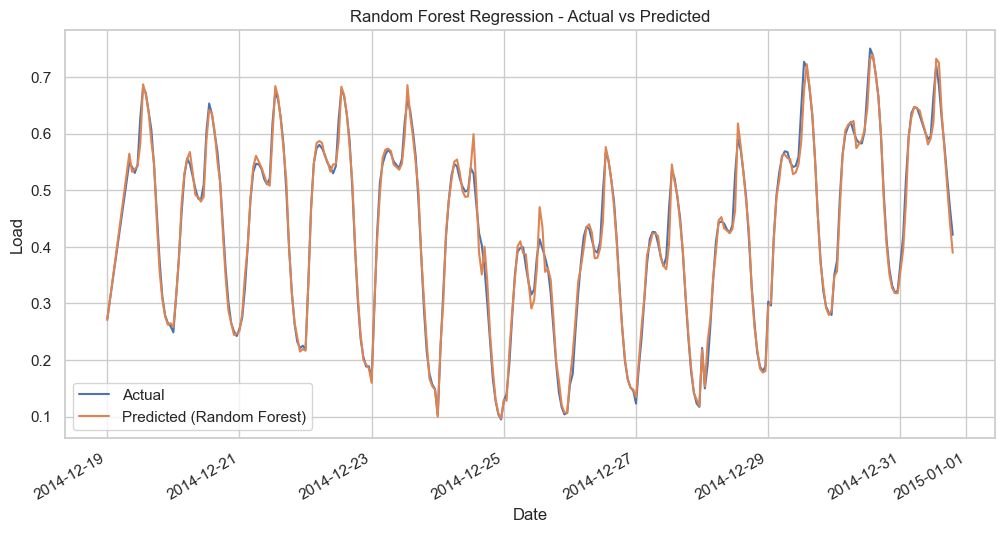

In [71]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_rf)
mae_dt = mean_absolute_error(y_test, y_pred_rf)
r2_dt = r2_score(y_test, y_pred_rf)

print("Mean Squared Error (Random Forest):", mse_dt)
print("Mean Absolute Error (Random Forest):", mae_dt)
print("R-squared (Random Forest):", r2_dt)

plt.figure(figsize=(12, 6))
y_test[-300:].plot(label='Actual')
pd.Series(y_pred_rf, index=y_test.index)[-300:].plot(label='Predicted (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Random Forest Regression - Actual vs Predicted')
plt.legend()
plt.show()

**6. Decision Tree**

Mean Squared Error (Decision Tree): 0.00047897771184698837
Mean Absolute Error (Decision Tree): 0.014286248956920487
R-squared (Decision Tree): 0.9809864242246208


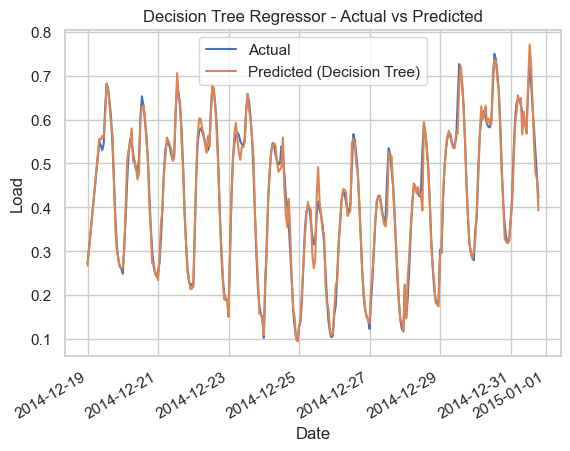

In [72]:
dt_regressor = DecisionTreeRegressor(random_state=42)

dt_regressor.fit(X_train, y_train)

y_pred_dt = dt_regressor.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Mean Squared Error (Decision Tree):", mse_dt)
print("Mean Absolute Error (Decision Tree):", mae_dt)
print("R-squared (Decision Tree):", r2_dt)

y_test[-300:].plot(label='Actual')
pd.Series(y_pred_dt, index=y_test.index)[-300:].plot(label='Predicted (Decision Tree)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Decision Tree Regressor - Actual vs Predicted')
plt.legend()
plt.show()

**7. XGBoost**

Mean Squared Error (XGBoost): 0.0002495141947078466
Mean Absolute Error (XGBoost): 0.0110972478272591
R-squared (XGBoost): 0.990095244662186


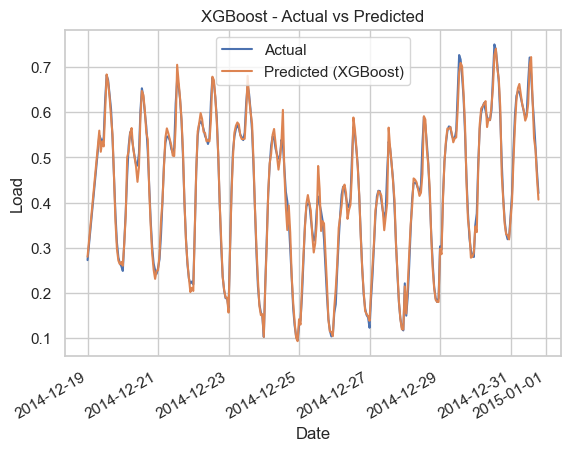

In [73]:
np.random.seed(42)

xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_xgb)
mae_dt = mean_absolute_error(y_test, y_pred_xgb)
r2_dt = r2_score(y_test, y_pred_xgb)

print("Mean Squared Error (XGBoost):", mse_dt)
print("Mean Absolute Error (XGBoost):", mae_dt)
print("R-squared (XGBoost):", r2_dt)

y_test[-300:].plot(label='Actual')
pd.Series(y_pred_xgb, index=y_test.index)[-300:].plot(label='Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('XGBoost - Actual vs Predicted')
plt.legend()
plt.show()

**8. SVR**

Mean Squared Error (SVR): 0.0015592019305049566
Mean Absolute Error (SVR): 0.03151757653612558
R-squared (SVR): 0.9381056710541803


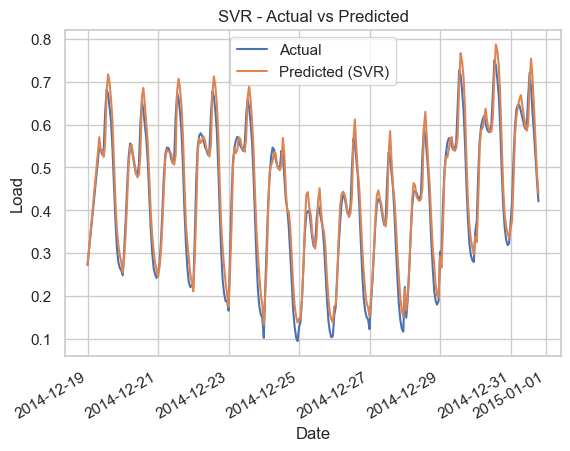

In [74]:
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_svr)
mae_dt = mean_absolute_error(y_test, y_pred_svr)
r2_dt = r2_score(y_test, y_pred_svr)

print("Mean Squared Error (SVR):", mse_dt)
print("Mean Absolute Error (SVR):", mae_dt)
print("R-squared (SVR):", r2_dt)

y_test[-300:].plot(label='Actual')
pd.Series(y_pred_svr, index=y_test.index)[-300:].plot(label='Predicted (SVR)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('SVR - Actual vs Predicted')
plt.legend()
plt.show()

### **Time series forecasting with Deep Learning**

**1. LSTM**

In [75]:
X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values

# Reshape the input data to be 3D for LSTM (samples, time steps, features)
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_array.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_reshaped, y_train_array, epochs=50, batch_size=32, verbose=1)

y_pred_lstm = model.predict(X_test_reshaped)

Epoch 1/50
549/549 [==============================] - 3s 2ms/step - loss: 0.0161
Epoch 2/50
549/549 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 3/50
549/549 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/50
549/549 [==============================] - 1s 3ms/step - loss: 9.4608e-04
Epoch 5/50
549/549 [==============================] - 1s 2ms/step - loss: 8.4099e-04
Epoch 6/50
549/549 [==============================] - 1s 2ms/step - loss: 7.7202e-04
Epoch 7/50
549/549 [==============================] - 1s 2ms/step - loss: 7.3017e-04
Epoch 8/50
549/549 [==============================] - 2s 3ms/step - loss: 7.0763e-04
Epoch 9/50
549/549 [==============================] - 1s 2ms/step - loss: 6.6271e-04
Epoch 10/50
549/549 [==============================] - 1s 2ms/step - loss: 6.4546e-04
Epoch 11/50
549/549 [==============================] - 1s 2ms/step - loss: 6.2154e-04
Epoch 12/50
549/549 [==============================] - 1s 2ms/step - loss: 

Mean Squared Error (LSTM): 0.00026625862790295485
Mean Absolute Error (LSTM): 0.011320075679349164
R-squared (LSTM): 0.9894305549668279


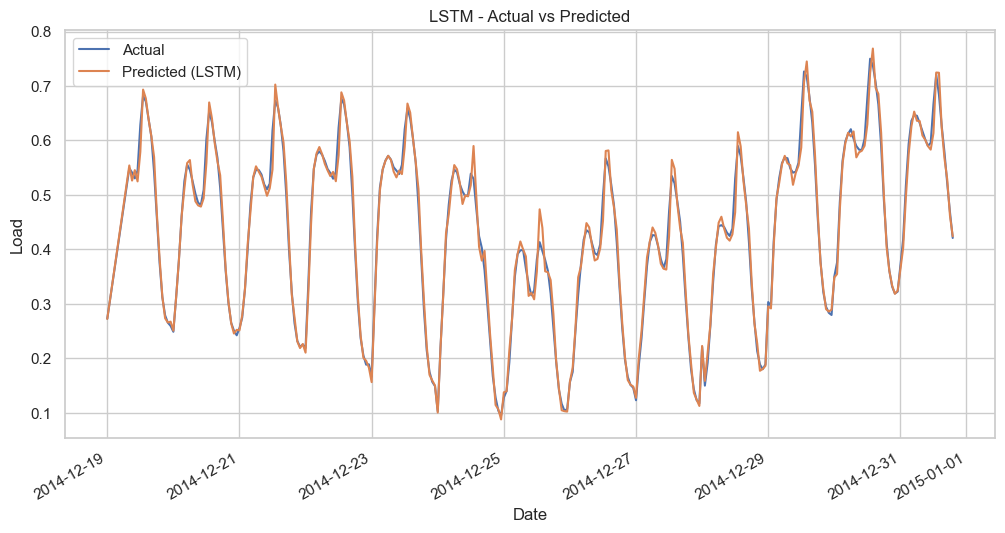

In [76]:
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print("Mean Squared Error (LSTM):", mse_lstm)
print("Mean Absolute Error (LSTM):", mae_lstm)
print("R-squared (LSTM):", r2_lstm)

plt.figure(figsize=(12, 6))
y_test[-300:].plot(label='Actual')
pd.Series(y_pred_lstm.flatten(), index=y_test.index)[-300:].plot(label='Predicted (LSTM)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('LSTM - Actual vs Predicted')
plt.legend()
plt.show()

**2. GRU**

In [77]:
X_train_gru = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(X_train_gru.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_gru, y_train, epochs=50, batch_size=32, verbose=1)

y_pred_gru = model.predict(X_test_gru)

Epoch 1/50
549/549 [==============================] - 4s 5ms/step - loss: 0.0137
Epoch 2/50
549/549 [==============================] - 3s 5ms/step - loss: 0.0014
Epoch 3/50
549/549 [==============================] - 2s 4ms/step - loss: 9.0500e-04
Epoch 4/50
549/549 [==============================] - 2s 4ms/step - loss: 7.9669e-04
Epoch 5/50
549/549 [==============================] - 2s 4ms/step - loss: 7.6432e-04
Epoch 6/50
549/549 [==============================] - 2s 4ms/step - loss: 7.6849e-04
Epoch 7/50
549/549 [==============================] - 2s 4ms/step - loss: 7.1266e-04
Epoch 8/50
549/549 [==============================] - 2s 4ms/step - loss: 6.6546e-04
Epoch 9/50
549/549 [==============================] - 3s 5ms/step - loss: 6.6342e-04
Epoch 10/50
549/549 [==============================] - 2s 4ms/step - loss: 6.3158e-04
Epoch 11/50
549/549 [==============================] - 3s 5ms/step - loss: 6.3595e-04
Epoch 12/50
549/549 [==============================] - 2s 5ms/step - lo

Mean Squared Error (GRU): 0.0006094470828797177
Mean Absolute Error (GRU): 0.020213001070060653
R-squared (GRU): 0.9758072912271144


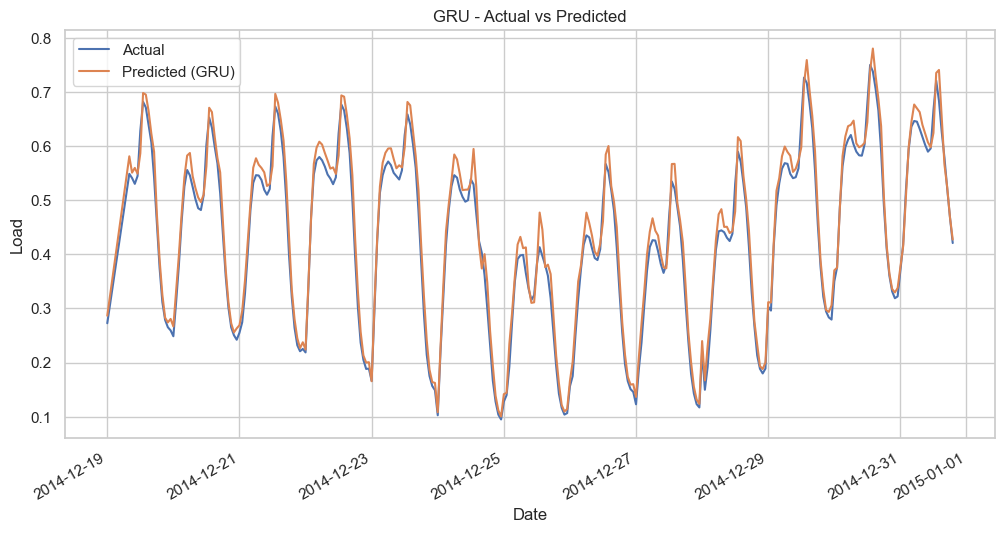

In [78]:
mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("Mean Squared Error (GRU):", mse_gru)
print("Mean Absolute Error (GRU):", mae_gru)
print("R-squared (GRU):", r2_gru)

plt.figure(figsize=(12, 6))
y_test[-300:].plot(label='Actual')
pd.Series(y_pred_gru.flatten(), index=y_test.index)[-300:].plot(label='Predicted (GRU)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('GRU - Actual vs Predicted')
plt.legend()
plt.show()

#### **Evalutating**

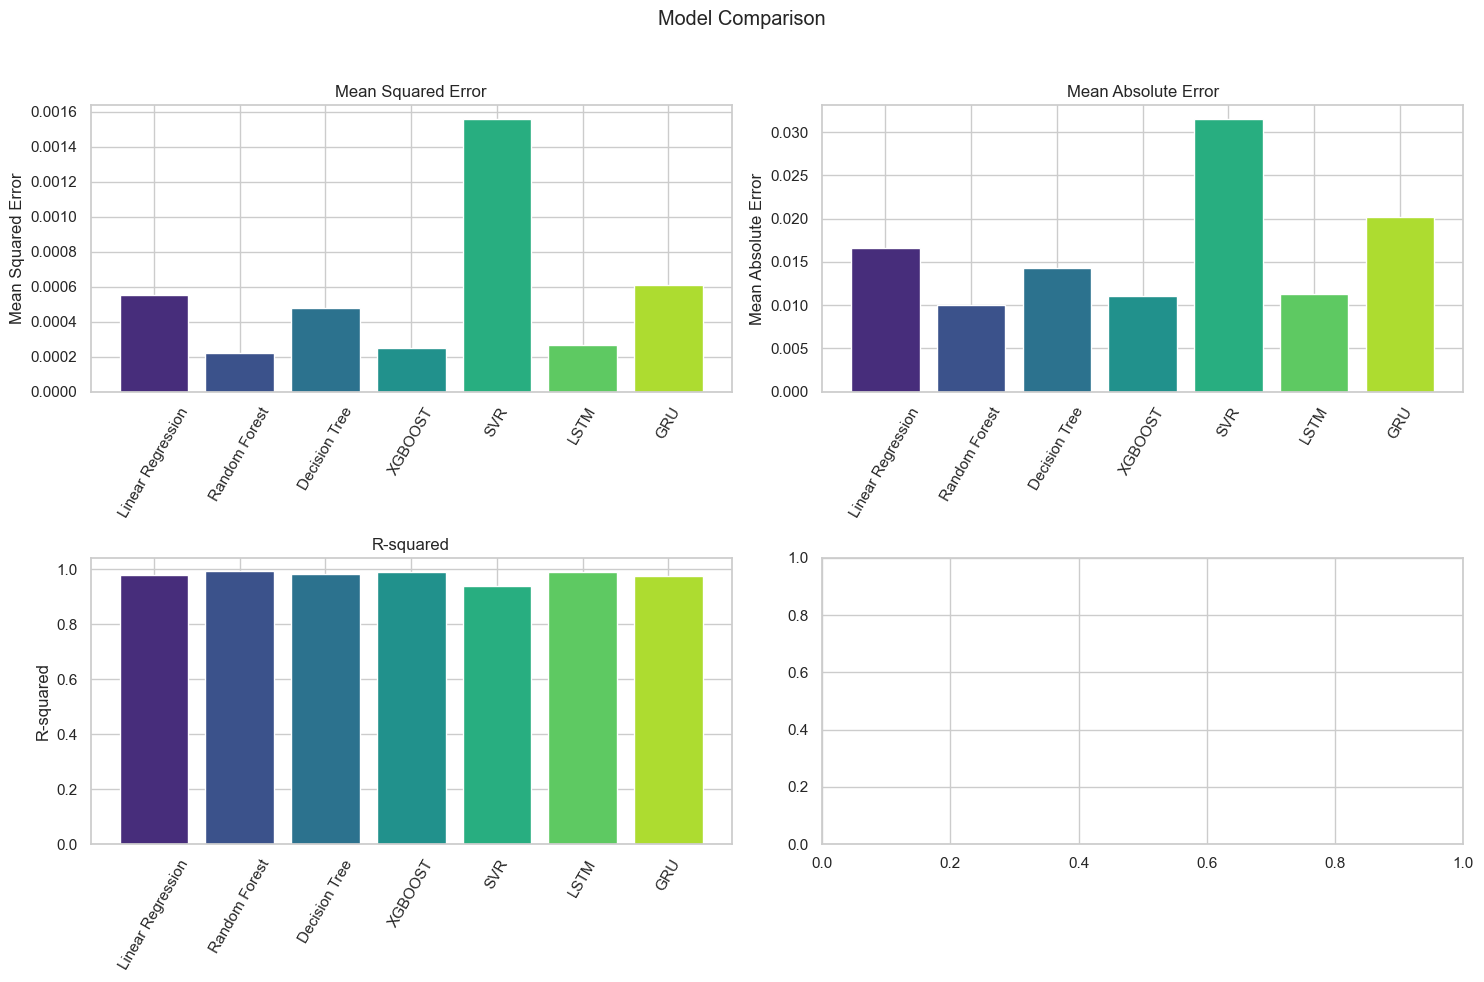

In [95]:
models = ['Linear Regression', 'Random Forest', 'Decision Tree', 'XGBOOST', 'SVR', 'LSTM', 'GRU']
y_preds = [y_pred_lr, y_pred_rf, y_pred_dt, y_pred_xgb, y_pred_svr, y_pred_lstm, y_pred_gru]

# Define the metrics you want to compare
metrics = {
    'Mean Squared Error': mean_squared_error,
    'Mean Absolute Error': mean_absolute_error,
    'R-squared': r2_score,
}

palette = sns.color_palette("viridis", n_colors=len(models))

# Calculate metrics for each model
results = {metric: [] for metric in metrics}

for metric, scorer in metrics.items():
    for y_pred in y_preds:
        result = scorer(y_test, y_pred)
        results[metric].append(result)

# Create a bar chart for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Model Comparison')

for i, (metric, values) in enumerate(results.items()):
    ax = axes[i // 2, i % 2]
    ax.bar(models, values, color=palette)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [98]:
print('MSE historical Mean', round(mse_mean, 3))
print('MSE last value', round(mse_last, 3))
print('MSE ARMA(2)', round(mse_ARMA, 3))

MSE historical Mean 301711.77
MSE last value 325566.248
MSE ARMA(2) 196935.768
